# MLP
MLP, K=5, droput, 150 epoch.

mRNA. Exclude test middle.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 15:11:16.380011


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_249'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None #'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_pc_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 15:11:50.178799
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = 0 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold) # lncRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold) # mRNA
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            # use -2 and 0 for lncRNA, use -1 and +1 for mRNA
            in_middle = gene_to_rci[gene_id] >= -1 and gene_to_rci[gene_id] <= 1
            in_tails = gene_to_rci[gene_id] < -1 or gene_to_rci[gene_id] > 1
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 15:11:50.825235
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13662
Num RCI: 13662
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_pc_transcripts.csv
Loaded 13662 sequences.

Training # 1 1
2023-04-09 15:12:48.723519
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
2023-04-09 15:12:48.963996
Discriminator ZERO 0
Train 1:0 5183:5746 47.42%
Valid 1:0 454:708 39.07%
FIT
2023-04-09 15:12:49.114143


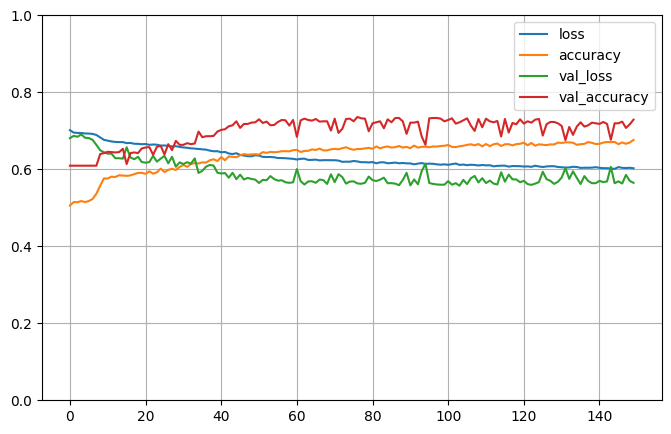


Testing # 1 1
2023-04-09 15:18:12.755935
2023-04-09 15:18:12.755981
PREDICT
2023-04-09 15:18:12.771951
Test 1:0 454:708 39.07%
Predict 1:0 403:759 34.68%
Test sizes (1162, 1025) (1162,)
Distrib of scores: 0.43276736 mean 0.20557873 std
Range of scores: 0.107410364 to 0.98457307
Score threshold 0.5
Confusion matrix
 [[576 132]
 [183 271]]
Normalized matrix
 [[0.49569707 0.11359725]
 [0.15748709 0.23321859]]
Extreme scores correct, pos:neg 161 394
Extreme scores incorrect pos:neg 44 89


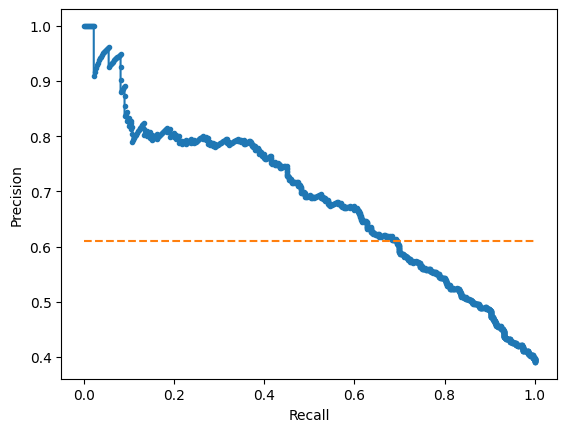

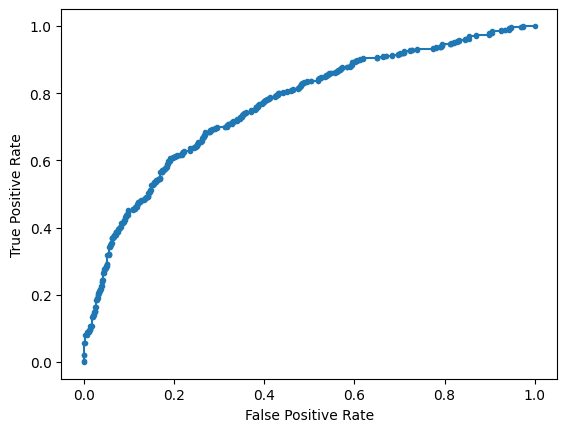

Accuracy: 72.89% Precision: 67.25% Recall: 59.69%
F1: 63.24% MCC: 0.4208
AUPRC: 68.66% AUROC: 76.38%
 accuracy [72.89156626506023]
 precision [67.24565756823822]
 recall [59.691629955947135]
 F1 [63.243873978996504]
 MCC [0.42078331762918714]
 AUPRC [68.6569148549449]
 AUROC [76.37851862913463]

Training # 1 2
2023-04-09 15:18:13.518027
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
2023-04-09 15:18:13.789597
Discriminator ZERO 0
Train 1:0 5124:5805 46.88%
Valid 1:0 511:666 43.42%
FIT
2023-04-09 15:18:13.921883


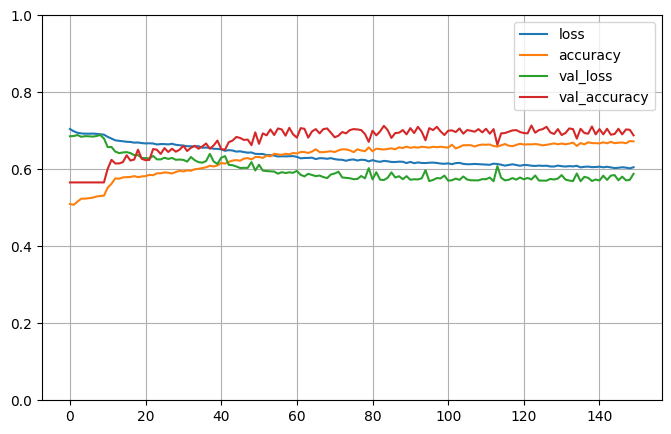


Testing # 1 2
2023-04-09 15:23:37.477996
2023-04-09 15:23:37.478083
PREDICT
2023-04-09 15:23:37.489403
Test 1:0 511:666 43.42%
Predict 1:0 586:591 49.79%
Test sizes (1177, 1025) (1177,)
Distrib of scores: 0.51616055 mean 0.21046112 std
Range of scores: 0.108419254 to 0.98348975
Score threshold 0.5
Confusion matrix
 [[445 221]
 [146 365]]
Normalized matrix
 [[0.37807986 0.18776551]
 [0.12404418 0.31011045]]
Extreme scores correct, pos:neg 242 258
Extreme scores incorrect pos:neg 78 56


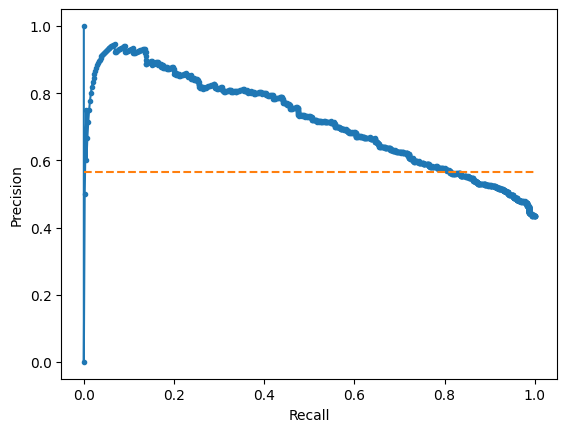

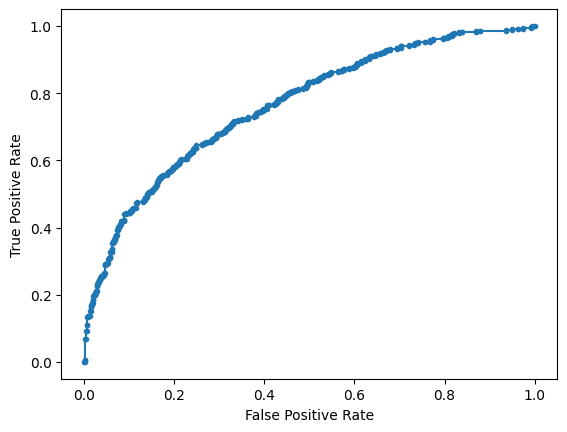

Accuracy: 68.82% Precision: 62.29% Recall: 71.43%
F1: 66.55% MCC: 0.3791
AUPRC: 71.69% AUROC: 76.32%
 accuracy [68.81903143585386]
 precision [62.28668941979522]
 recall [71.42857142857143]
 F1 [66.54512306289881]
 MCC [0.3791264551305384]
 AUPRC [71.68594461962533]
 AUROC [76.31623796007358]

Training # 1 3
2023-04-09 15:23:38.227908
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
2023-04-09 15:23:38.463487
Discriminator ZERO 0
Train 1:0 5152:5778 47.14%
Valid 1:0 478:706 40.37%
FIT
2023-04-09 15:23:38.666846


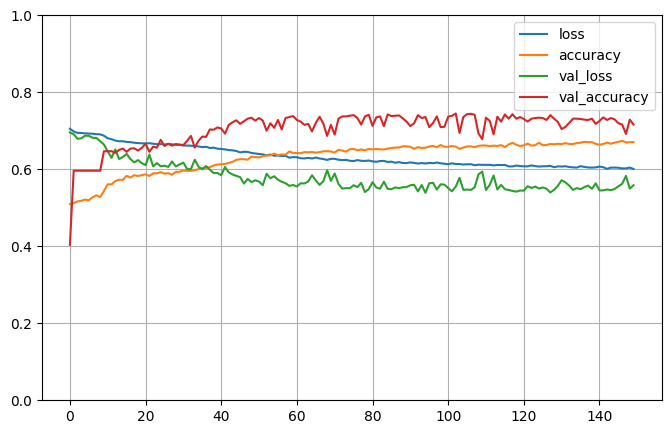


Testing # 1 3
2023-04-09 15:28:02.047869
2023-04-09 15:28:02.047932
PREDICT
2023-04-09 15:28:02.062221
Test 1:0 478:706 40.37%
Predict 1:0 492:692 41.55%
Test sizes (1184, 1025) (1184,)
Distrib of scores: 0.47269765 mean 0.20868331 std
Range of scores: 0.09716221 to 0.97194123
Score threshold 0.5
Confusion matrix
 [[531 175]
 [161 317]]
Normalized matrix
 [[0.44847973 0.14780405]
 [0.13597973 0.26773649]]
Extreme scores correct, pos:neg 194 332
Extreme scores incorrect pos:neg 57 55


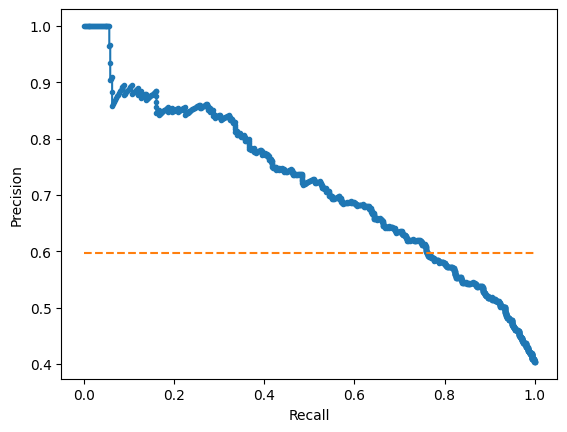

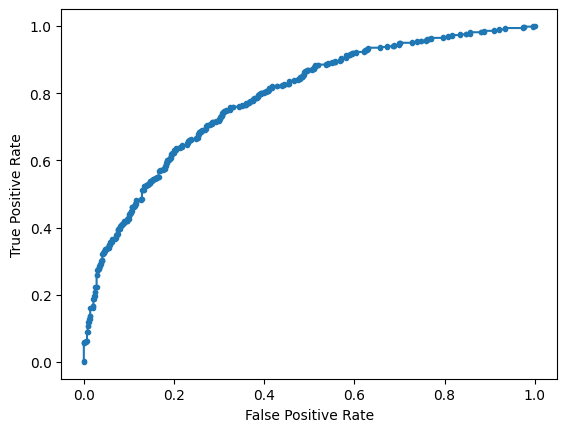

Accuracy: 71.62% Precision: 64.43% Recall: 66.32%
F1: 65.36% MCC: 0.4135
AUPRC: 72.08% AUROC: 78.58%
 accuracy [71.62162162162163]
 precision [64.43089430894308]
 recall [66.31799163179917]
 F1 [65.36082474226804]
 MCC [0.4134732351711529]
 AUPRC [72.08139398573846]
 AUROC [78.58033946922376]

Training # 1 4
2023-04-09 15:28:02.685562
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
2023-04-09 15:28:02.983274
Discriminator ZERO 0
Train 1:0 5181:5749 47.40%
Valid 1:0 463:709 39.51%
FIT
2023-04-09 15:28:03.142386


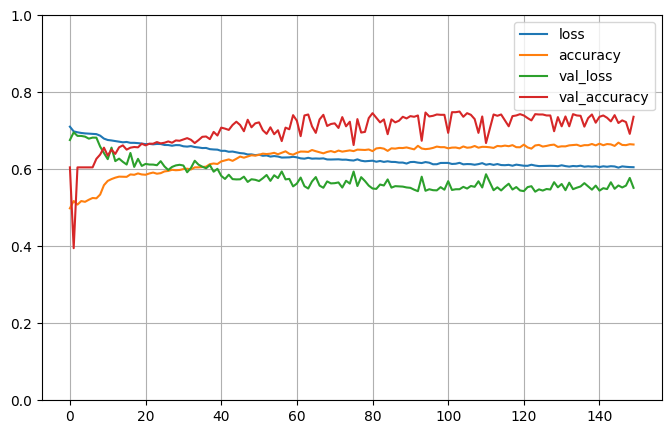


Testing # 1 4
2023-04-09 15:32:26.484570
2023-04-09 15:32:26.484710
PREDICT
2023-04-09 15:32:26.505969
Test 1:0 463:709 39.51%
Predict 1:0 468:704 39.93%
Test sizes (1172, 1025) (1172,)
Distrib of scores: 0.45457408 mean 0.21757345 std
Range of scores: 0.061191373 to 0.9762849
Score threshold 0.5
Confusion matrix
 [[552 157]
 [152 311]]
Normalized matrix
 [[0.47098976 0.13395904]
 [0.12969283 0.26535836]]
Extreme scores correct, pos:neg 182 360
Extreme scores incorrect pos:neg 52 64


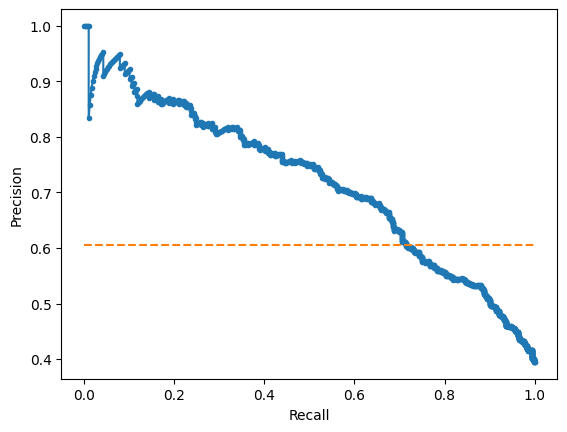

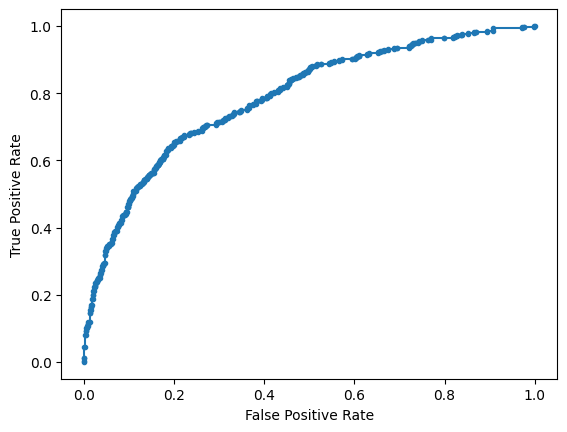

Accuracy: 73.63% Precision: 66.45% Recall: 67.17%
F1: 66.81% MCC: 0.4494
AUPRC: 71.71% AUROC: 78.64%
 accuracy [73.63481228668942]
 precision [66.45299145299145]
 recall [67.170626349892]
 F1 [66.80988184747582]
 MCC [0.4494434663236412]
 AUPRC [71.70603783230015]
 AUROC [78.64208098895107]

Training # 1 5
2023-04-09 15:32:27.437511
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
2023-04-09 15:32:27.681565
Discriminator ZERO 0
Train 1:0 5120:5810 46.84%
Valid 1:0 496:699 41.51%
FIT
2023-04-09 15:32:27.892999


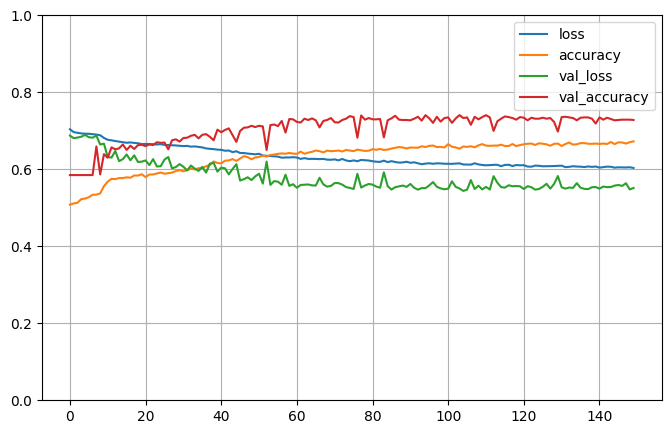


Testing # 1 5
2023-04-09 15:37:51.726385
2023-04-09 15:37:51.726437
PREDICT
2023-04-09 15:37:51.740995
Test 1:0 496:699 41.51%
Predict 1:0 485:710 40.59%
Test sizes (1195, 1025) (1195,)
Distrib of scores: 0.45099264 mean 0.21993633 std
Range of scores: 0.060293466 to 0.966751
Score threshold 0.5
Confusion matrix
 [[542 157]
 [168 328]]
Normalized matrix
 [[0.45355649 0.13138075]
 [0.14058577 0.27447699]]
Extreme scores correct, pos:neg 194 373
Extreme scores incorrect pos:neg 55 78


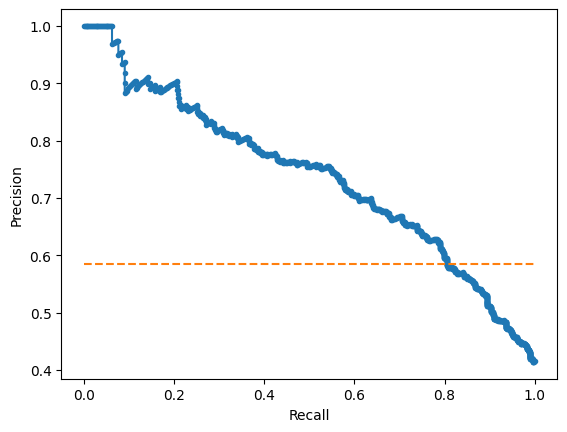

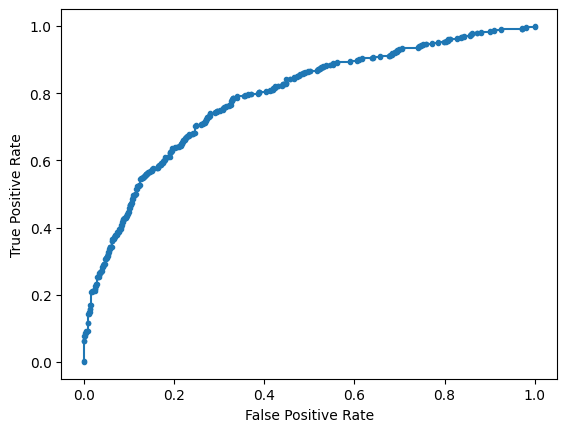

Accuracy: 72.80% Precision: 67.63% Recall: 66.13%
F1: 66.87% MCC: 0.4382
AUPRC: 73.72% AUROC: 78.68%
 accuracy [72.80334728033473]
 precision [67.62886597938144]
 recall [66.12903225806451]
 F1 [66.87054026503567]
 MCC [0.43817379942080736]
 AUPRC [73.72172190151448]
 AUROC [78.68498777054778]

Training # 2 1
2023-04-09 15:37:52.374435
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
2023-04-09 15:37:52.644370
Discriminator ZERO 0
Train 1:0 5143:5786 47.06%
Valid 1:0 478:684 41.14%
FIT
2023-04-09 15:37:52.786216


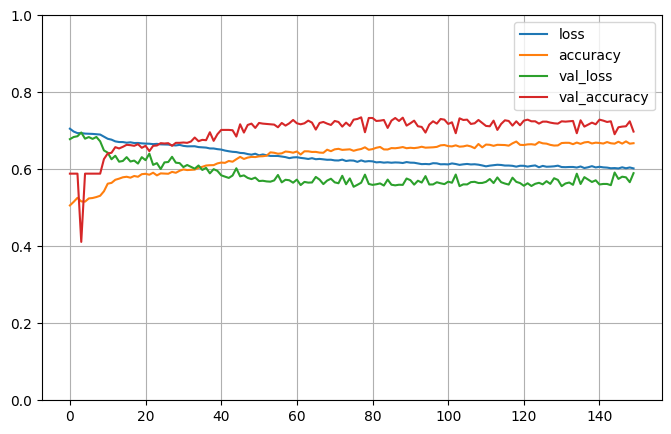


Testing # 2 1
2023-04-09 15:42:16.195813
2023-04-09 15:42:16.196215
PREDICT
2023-04-09 15:42:16.211550
Test 1:0 478:684 41.14%
Predict 1:0 593:569 51.03%
Test sizes (1162, 1025) (1162,)
Distrib of scores: 0.51687604 mean 0.2060346 std
Range of scores: 0.07358705 to 0.9884543
Score threshold 0.5
Confusion matrix
 [[451 233]
 [118 360]]
Normalized matrix
 [[0.38812392 0.20051635]
 [0.10154905 0.30981067]]
Extreme scores correct, pos:neg 237 237
Extreme scores incorrect pos:neg 92 37


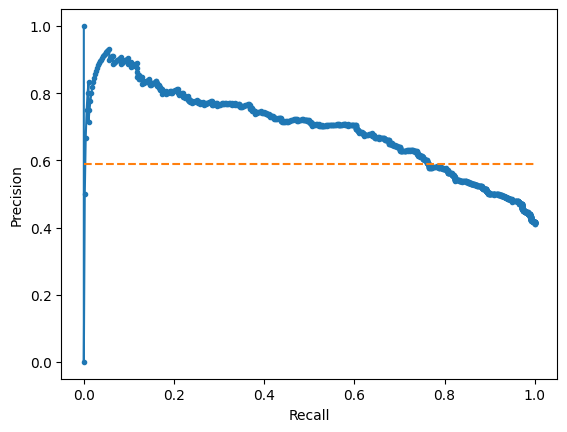

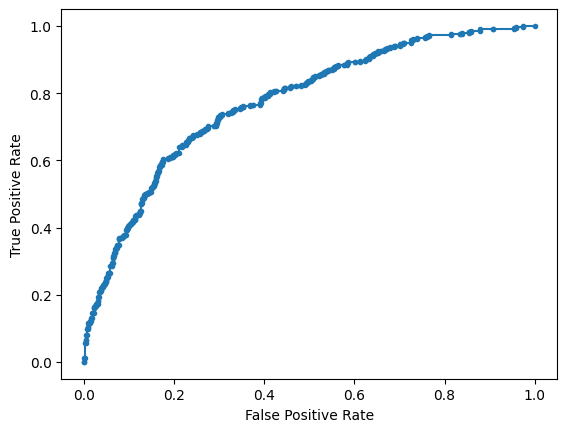

Accuracy: 69.79% Precision: 60.71% Recall: 75.31%
F1: 67.23% MCC: 0.4060
AUPRC: 69.42% AUROC: 77.34%
 accuracy [69.79345955249569]
 precision [60.70826306913997]
 recall [75.31380753138075]
 F1 [67.22689075630251]
 MCC [0.40604764675070687]
 AUPRC [69.41529607008972]
 AUROC [77.33795786537473]

Training # 2 2
2023-04-09 15:42:16.922823
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
2023-04-09 15:42:17.146187
Discriminator ZERO 0
Train 1:0 5176:5753 47.36%
Valid 1:0 472:719 39.63%
FIT
2023-04-09 15:42:17.289892


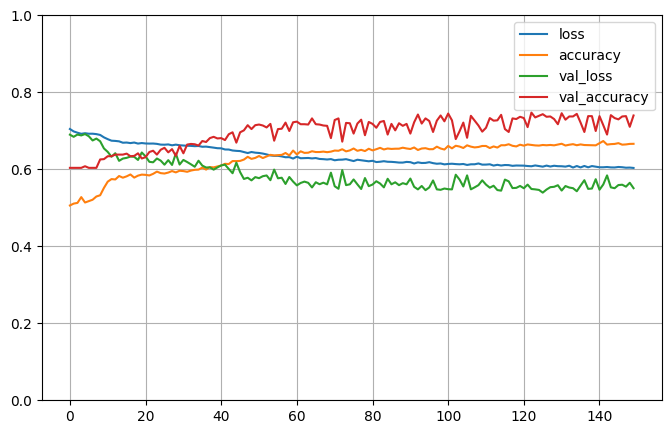


Testing # 2 2
2023-04-09 15:46:40.565186
2023-04-09 15:46:40.565260
PREDICT
2023-04-09 15:46:40.578411
Test 1:0 472:719 39.63%
Predict 1:0 484:707 40.64%
Test sizes (1191, 1025) (1191,)
Distrib of scores: 0.45618802 mean 0.22184166 std
Range of scores: 0.064667806 to 0.9793454
Score threshold 0.5
Confusion matrix
 [[558 161]
 [149 323]]
Normalized matrix
 [[0.46851385 0.13518052]
 [0.12510495 0.27120067]]
Extreme scores correct, pos:neg 193 352
Extreme scores incorrect pos:neg 54 67


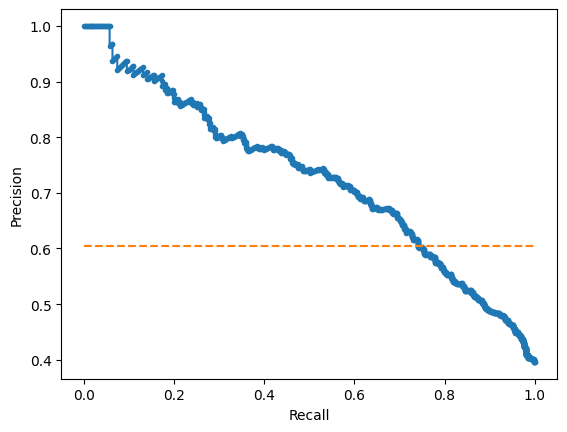

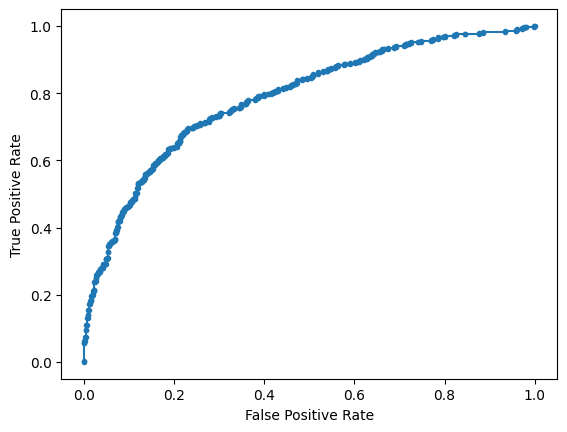

Accuracy: 73.97% Precision: 66.74% Recall: 68.43%
F1: 67.57% MCC: 0.4585
AUPRC: 72.66% AUROC: 78.67%
 accuracy [73.97145256087322]
 precision [66.73553719008265]
 recall [68.4322033898305]
 F1 [67.57322175732216]
 MCC [0.45849889795638743]
 AUPRC [72.66117185498376]
 AUROC [78.66504797152353]

Training # 2 3
2023-04-09 15:46:42.269706
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
2023-04-09 15:46:42.523883
Discriminator ZERO 0
Train 1:0 5135:5794 46.99%
Valid 1:0 471:657 41.76%
FIT
2023-04-09 15:46:42.729686


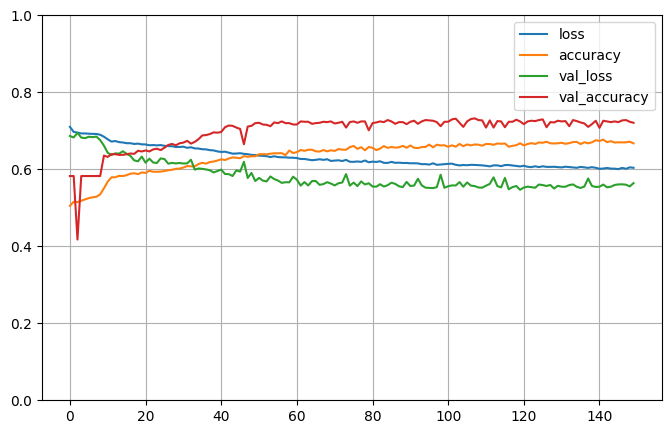


Testing # 2 3
2023-04-09 15:52:06.545145
2023-04-09 15:52:06.545206
PREDICT
2023-04-09 15:52:06.560398
Test 1:0 471:657 41.76%
Predict 1:0 350:778 31.03%
Test sizes (1128, 1025) (1128,)
Distrib of scores: 0.4360309 mean 0.17917445 std
Range of scores: 0.105377495 to 0.9857665
Score threshold 0.5
Confusion matrix
 [[560  97]
 [218 253]]
Normalized matrix
 [[0.4964539  0.08599291]
 [0.19326241 0.22429078]]
Extreme scores correct, pos:neg 122 337
Extreme scores incorrect pos:neg 20 65


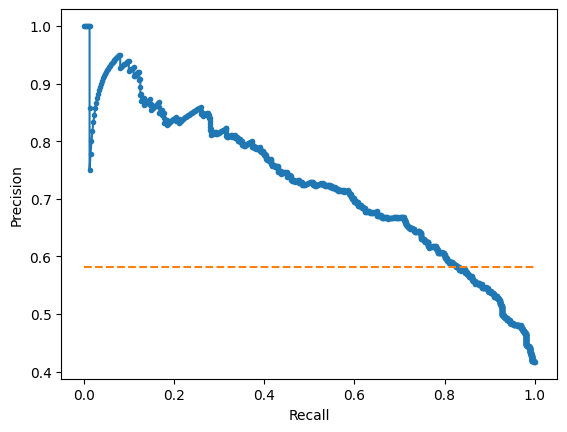

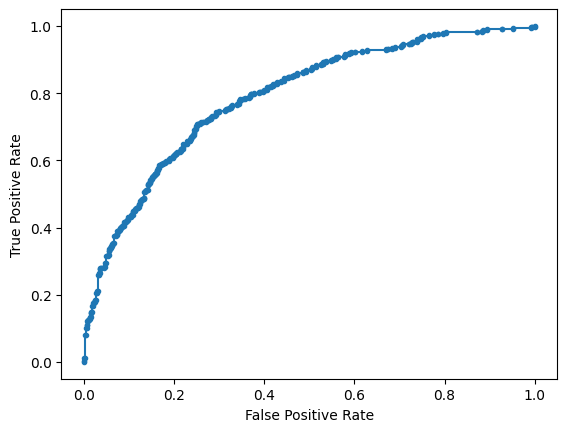

Accuracy: 72.07% Precision: 72.29% Recall: 53.72%
F1: 61.63% MCC: 0.4152
AUPRC: 72.56% AUROC: 78.86%
 accuracy [72.07446808510637]
 precision [72.28571428571429]
 recall [53.71549893842887]
 F1 [61.632155907429954]
 MCC [0.4152337161649257]
 AUPRC [72.56289194108139]
 AUROC [78.85582991594683]

Training # 2 4
2023-04-09 15:52:07.210763
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
2023-04-09 15:52:07.459639
Discriminator ZERO 0
Train 1:0 5126:5804 46.90%
Valid 1:0 512:717 41.66%
FIT
2023-04-09 15:52:07.599538


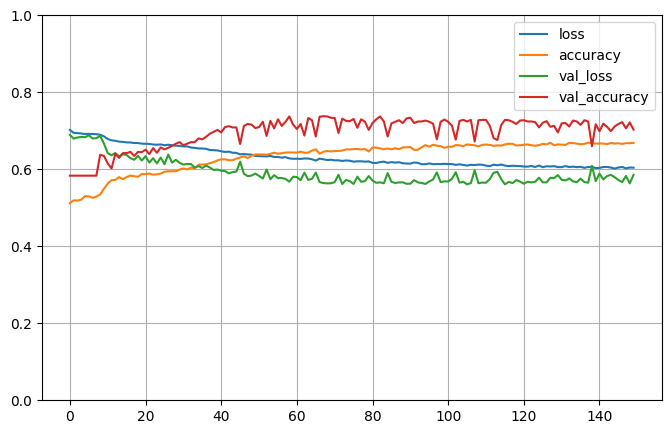


Testing # 2 4
2023-04-09 15:57:30.974210
2023-04-09 15:57:30.974615
PREDICT
2023-04-09 15:57:30.985932
Test 1:0 512:717 41.66%
Predict 1:0 597:632 48.58%
Test sizes (1229, 1025) (1229,)
Distrib of scores: 0.50634456 mean 0.22112615 std
Range of scores: 0.08315829 to 0.981139
Score threshold 0.5
Confusion matrix
 [[492 225]
 [140 372]]
Normalized matrix
 [[0.40032547 0.18307567]
 [0.11391375 0.30268511]]
Extreme scores correct, pos:neg 256 299
Extreme scores incorrect pos:neg 96 61


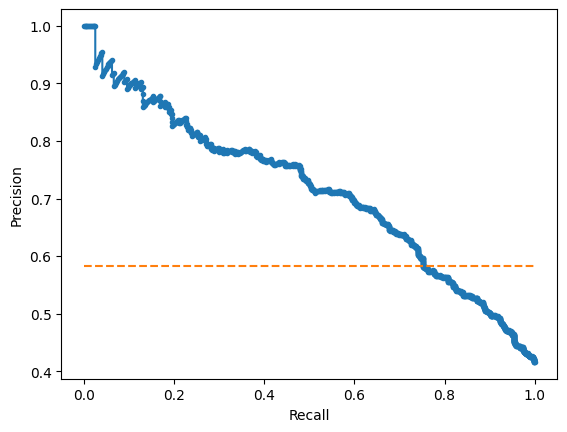

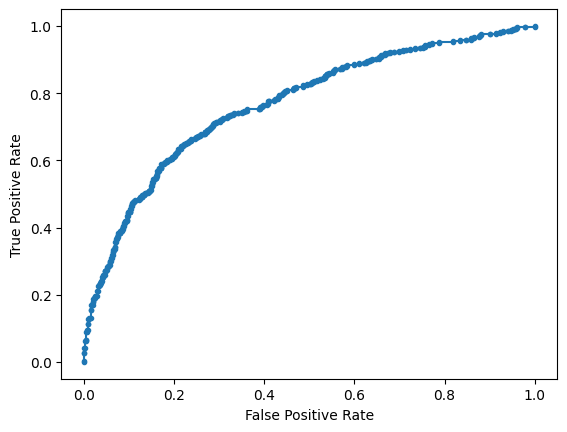

Accuracy: 70.30% Precision: 62.31% Recall: 72.66%
F1: 67.09% MCC: 0.4071
AUPRC: 71.32% AUROC: 76.70%
 accuracy [70.30105777054516]
 precision [62.311557788944725]
 recall [72.65625]
 F1 [67.08746618575293]
 MCC [0.4071375543094768]
 AUPRC [71.31976047298484]
 AUROC [76.70442163528591]

Training # 2 5
2023-04-09 15:57:31.940095
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
2023-04-09 15:57:32.390535
Discriminator ZERO 0
Train 1:0 5180:5751 47.39%
Valid 1:0 469:711 39.75%
FIT
2023-04-09 15:57:32.583262


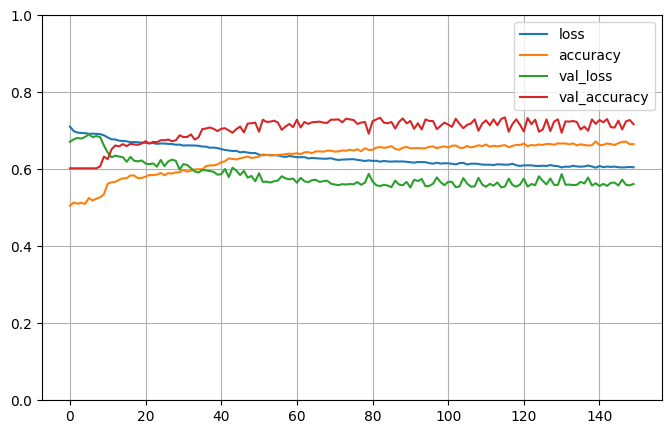


Testing # 2 5
2023-04-09 16:01:56.232006
2023-04-09 16:01:56.232068
PREDICT
2023-04-09 16:01:56.244299
Test 1:0 469:711 39.75%
Predict 1:0 425:755 36.02%
Test sizes (1180, 1025) (1180,)
Distrib of scores: 0.44618458 mean 0.21247208 std
Range of scores: 0.11163709 to 0.9849535
Score threshold 0.5
Confusion matrix
 [[566 145]
 [189 280]]
Normalized matrix
 [[0.47966102 0.12288136]
 [0.16016949 0.23728814]]
Extreme scores correct, pos:neg 177 376
Extreme scores incorrect pos:neg 43 82


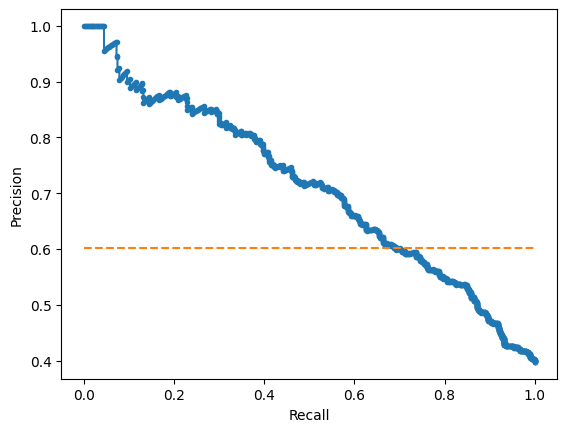

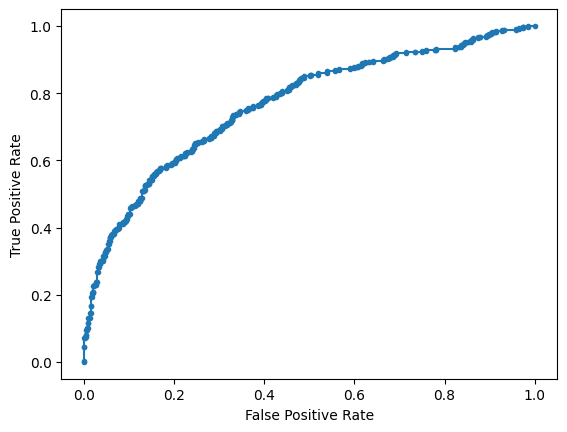

Accuracy: 71.69% Precision: 65.88% Recall: 59.70%
F1: 62.64% MCC: 0.4007
AUPRC: 71.01% AUROC: 76.62%
 accuracy [71.69491525423729]
 precision [65.88235294117646]
 recall [59.70149253731343]
 F1 [62.639821029082775]
 MCC [0.40071048267723064]
 AUPRC [71.00746675858936]
 AUROC [76.61661553594294]
2023-04-09 16:01:56.963189


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 71.76% std 1.68
 precision mean 65.60% std 3.35
 recall mean 66.06% std 6.65
 F1 mean 65.50% std 2.18
 MCC mean 0.4189 std 0.0239
 AUPRC mean 71.48% std 1.51
 AUROC mean 77.68% std 1.10
 accuracy [[72.89156626506023], [68.81903143585386], [71.62162162162163], [73.63481228668942], [72.80334728033473], [69.79345955249569], [73.97145256087322], [72.07446808510637], [70.30105777054516], [71.69491525423729]]
 precision [[67.24565756823822], [62.28668941979522], [64.43089430894308], [66.45299145299145], [67.62886597938144], [60.70826306913997], [66.73553719008265], [72.28571428571429], [62.311557788944725], [65.88235294117646]]
 recall [[59.691629955947135], [71.42857142857143], [66.31799163179917], [67.170626349892], [66.12903225806451], [75.31380753138075], [68.4322033898305], [53.71549893842887], [72.65625], [59.70149253731343]]
 F1 [[63.243873978996504], [66.54512306289881], [65.36082474226804], [66.80988184747582], [66.87054026503567], [67.22689075630251], [67.57322175732